# Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas_datareader import data as pdr
import plotly.graph_objects as go
from fredapi import Fred
import datetime
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
import warnings
from io import StringIO
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import seaborn as sns
from tabulate import tabulate


# Data

## Importation of the datas

Producer Price Index by Commodity for Stage of Processing: Intermediate Energy Goods - WPUSOP2910
https://fred.stlouisfed.org/series/WPUSOP2910

In [2]:
def get_df_yahoo_f1(tickers):

    yf.pdr_override()
    close_prices = pd.DataFrame()
    
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start='2000-01-01', end='2005-12-31')
        close_prices[ticker] = data['Close']
        
    close_prices=(close_prices
        .resample('MS').mean()
        .dropna())

    return close_prices

def get_df_yahoo_f(tickers):

    yf.pdr_override()
    close_prices = pd.DataFrame()
    
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start='2005-01-01', end='2013-12-31')
        close_prices[ticker] = data['Close']
        
    close_prices=(close_prices
        .resample('MS').mean()
        .dropna())
    #close_prices=np.log(close_prices)
    return close_prices

def get_df_yahoo_f_stationary(tickers):
    yf.pdr_override()
    close_prices = pd.DataFrame()

    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start='2004-11-01', end='2013-12-31')
        close_prices[ticker] = data['Close']
    close_prices=(close_prices
        .resample('MS').mean()
        .pct_change()
        .dropna())
    
    return close_prices

In [3]:
tickers=['MSFT','^NDX']
# tickers=['AAPL','^GSPC']
monthly_mean_close_prices = get_df_yahoo_f_stationary(tickers)
initial_financial_datas = get_df_yahoo_f(tickers)
df_initial_data_msft=get_df_yahoo_f(['MSFT'])
df_initial_data_ndx=get_df_yahoo_f(['^NDX'])


# Download historical data for a macroeconomic series (Producer Price Index by Commodity for Stage of Processing: Intermediate Energy Goods - WPUSOP2910)
macro = pdr.get_data_fred('WPUSOP2910' , start='2005-01-01', end='2013-12-31')
processed_macro=macro.pct_change()


# Combine all series into a single DataFrame
data = pd.concat([monthly_mean_close_prices , processed_macro], axis=1).dropna()
df_initial_data = pd.concat([initial_financial_datas, macro], axis = 1)

data.columns = ['MSFT_sea_adj', 'NASDAQ_sea_adj', 'PPI_sea_adj']
df_initial_data.columns = ['MSFT', 'NASDAQ', 'PPI']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df_initial_data_msft

,MSFT
Date,
2005-01-01,26.328000
2005-02-01,25.837895
2005-03-01,24.735455
2005-04-01,24.786190
2005-05-01,25.469524
...,...
2013-08-01,32.485000
2013-09-01,32.523500
2013-10-01,34.382174


## Plot my dataframes

In [5]:
def plot_dataframe(df: pd.DataFrame, title: str):
    all_trace = []
    cols=' '
    #fig = go.Figure()

    for column in df.columns:
        trace = go.Scatter(x=df[column].dropna().index, y=df[column].dropna(), mode='lines', name=column)
        all_trace.append(trace)
        #fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=column))
        cols=cols+column + ' '

        layout = go.Layout(title=f'Comparision of time series: {cols}',
                        xaxis_title='Date',
                        yaxis_title=title)
    
    fig = go.Figure(data=all_trace, layout=layout)
    return(fig)
    #fig.update_layout(title=f'Comparaison des séries temporelles{cols}', xaxis_title='Date', yaxis_title='Evolution par rapport à la periode précedente')
    #fig.show()

plot_dataframe(df_initial_data, 'Evolution since the last period')




In [6]:
plot_dataframe(df_initial_data_msft, 'price')

In [7]:
plot_dataframe(df_initial_data_ndx, 'log-price')

In [8]:
plot_dataframe(initial_financial_datas, 'log-price')

In [9]:
plot_dataframe(data, 'Evolution since the last periode with one differenciation')

In [10]:
# Assuming df is your DataFrame
correlation_matrix = df_initial_data.corr()
correlation_matrix_2 = data.corr()

print(correlation_matrix)
print(correlation_matrix_2)



            MSFT    NASDAQ       PPI
MSFT    1.000000  0.718831  0.404222
NASDAQ  0.718831  1.000000  0.725589
PPI     0.404222  0.725589  1.000000
                MSFT_sea_adj  NASDAQ_sea_adj  PPI_sea_adj
MSFT_sea_adj        1.000000        0.697133     0.144251
NASDAQ_sea_adj      0.697133        1.000000     0.284850
PPI_sea_adj         0.144251        0.284850     1.000000


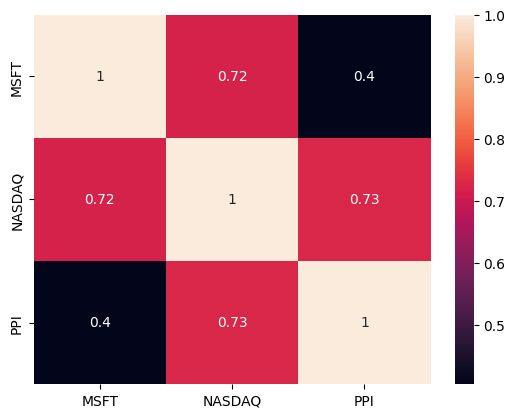

In [11]:
sns.heatmap(correlation_matrix, annot=True)
plt.show()

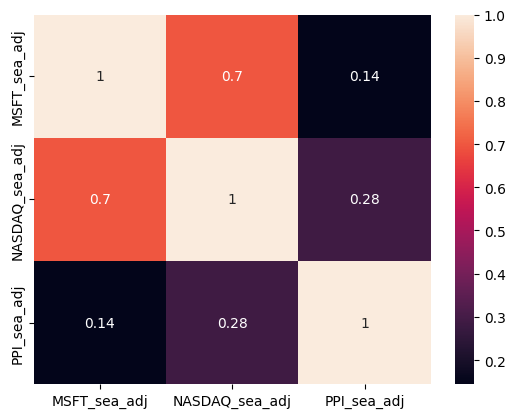

In [12]:
sns.heatmap(correlation_matrix_2, annot=True)
plt.show()

## Stationarity Test

In [13]:
def ad_fuller_test(df):
    results = []

    for column in df.columns:
        result = adfuller(df[column].dropna())
        p_value = result[1]
        is_stationary = "Stationary" if p_value < 0.05 else "Not Stationary"
        results.append([column, result[0], p_value, is_stationary])

    headers = ["Column", "ADF Statistic", "P-Value", "Stationary"]

    print(tabulate(results, headers=headers, tablefmt="grid"))

print('ADF Test with raw data:\n')
ad_fuller_test(df_initial_data)
print('ADF Test with one differenciation data:\n')
ad_fuller_test(data)

ADF Test with raw data:

+----------+-----------------+-----------+----------------+
| Column   |   ADF Statistic |   P-Value | Stationary     |
+==========+=================+===========+================+
| MSFT     |       -1.95801  |  0.305282 | Not Stationary |
+----------+-----------------+-----------+----------------+
| NASDAQ   |        0.418065 |  0.982158 | Not Stationary |
+----------+-----------------+-----------+----------------+
| PPI      |       -2.20222  |  0.20544  | Not Stationary |
+----------+-----------------+-----------+----------------+
ADF Test with one differenciation data:

+----------------+-----------------+-------------+--------------+
| Column         |   ADF Statistic |     P-Value | Stationary   |
+================+=================+=============+==============+
| MSFT_sea_adj   |        -7.45093 | 5.67342e-11 | Stationary   |
+----------------+-----------------+-------------+--------------+
| NASDAQ_sea_adj |        -7.28568 | 1.46104e-10 | Stationary   

In [14]:
def ad_fuller_test(df):

    for column in df.columns:
        result = adfuller(df[column].dropna())
        print(f'ADF Statistic for {column}: {result[0]}')
        print(result)
        print(f'p-value: {result[1]}')
        if result[1] < 0.05:
            print(f'{column} is stationary\n')
        else:
            print(f'{column} is not stationary\n')

print('ADF Test with raw data:\n')
ad_fuller_test(df_initial_data)
print('ADF Test with one differenciation data:\n')
ad_fuller_test(data)

ADF Test with raw data:

ADF Statistic for MSFT: -1.958010191467251
(-1.958010191467251, 0.30528203606910714, 2, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, 339.0406074557592)
p-value: 0.30528203606910714
MSFT is not stationary

ADF Statistic for NASDAQ: 0.41806513104603327
(0.41806513104603327, 0.9821580857233455, 1, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 1118.2776650416317)
p-value: 0.9821580857233455
NASDAQ is not stationary

ADF Statistic for PPI: -2.2022214393927295
(-2.2022214393927295, 0.20544019068235564, 5, 102, {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}, 635.2409834953535)
p-value: 0.20544019068235564
PPI is not stationary

ADF Test with one differenciation data:

ADF Statistic for MSFT_sea_adj: -7.450927642135359
(-7.450927642135359, 5.673417216311244e-11, 0, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 

All our initial series are I(1) 

# Data Analysis

## Johansen test for cointegration

In [15]:
# Perform the Johansen Cointegration Test
# det_order = 0 for no deterministic trend, k_ar_diff = 1 for lag order
jres = coint_johansen(df_initial_data, det_order=0, k_ar_diff=1)

# You can then analyze the result 'jres' to understand the cointegration relationships.
# For example, to print the test statistic and critical values:
print("Eigenvalues:", jres.eig)
print("Test Statistics:", jres.lr1)
print("Critical Values (90%, 95%, 99%):", jres.cvt)

Eigenvalues: [0.15207782 0.09596783 0.01533336]
Test Statistics: [29.8187421  12.33230136  1.63792603]
Critical Values (90%, 95%, 99%): [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [16]:
# Checking for Cointegration
coint_test = select_coint_rank(df_initial_data, det_order=1, k_ar_diff=1, method='trace', signif=0.05)
print("Cointegration Test Results:")
print(coint_test.summary())

# Fitting the VECM model
vecm = VECM(df_initial_data, k_ar_diff=1, coint_rank=1)
vecm_fit = vecm.fit()
print("VECM Results:")
print(vecm_fit.summary())

Cointegration Test Results:
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          33.44          35.01
-------------------------------------
VECM Results:
Det. terms outside the coint. relation & lagged endog. parameters for equation MSFT
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.MSFT        0.2525      0.125      2.026      0.043       0.008       0.497
L1.NASDAQ      0.0028      0.002      1.297      0.195      -0.001       0.007
L1.PPI         0.0025      0.018      0.139      0.890      -0.033       0.038
Det. terms outside the coint. relation & lagged endog. parameters for equation NASDAQ
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L

In [17]:
def analyze_residuals(data, column_name):
    # Fit the VECM model to the data
    vecm = VECM(data)
    vecm_fit = vecm.fit()

    # Get the residuals of the short-run equation
    residuals = vecm_fit.resid

    # Select the residuals of the return rate of interest
    selected_residuals = residuals[:, data.columns.get_loc(column_name)]

    # Performing the Augmented Dickey-Fuller test to check stationarity of residuals
    adf_test = adfuller(selected_residuals)
    print('ADF Statistic:', adf_test[0])
    print('p-value:', adf_test[1])

    # Plotting the Auto-correlogram
    fig, ax = plt.subplots(figsize=(10, 6))
    sm.graphics.tsa.plot_acf(selected_residuals, lags=40, ax=ax)
    plt.title(f'Auto-correlogram of {column_name} Return Rate Residuals')
    plt.show()


ADF Statistic: -8.092728824526999
p-value: 1.3644986644952997e-12


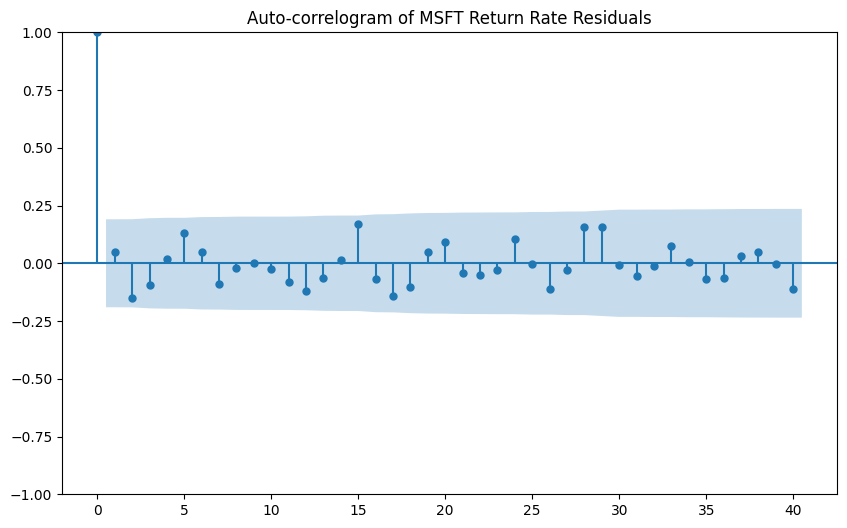

In [18]:
analyze_residuals(df_initial_data, 'MSFT')

ADF Statistic: -10.21911000335497
p-value: 5.3831183725264646e-18


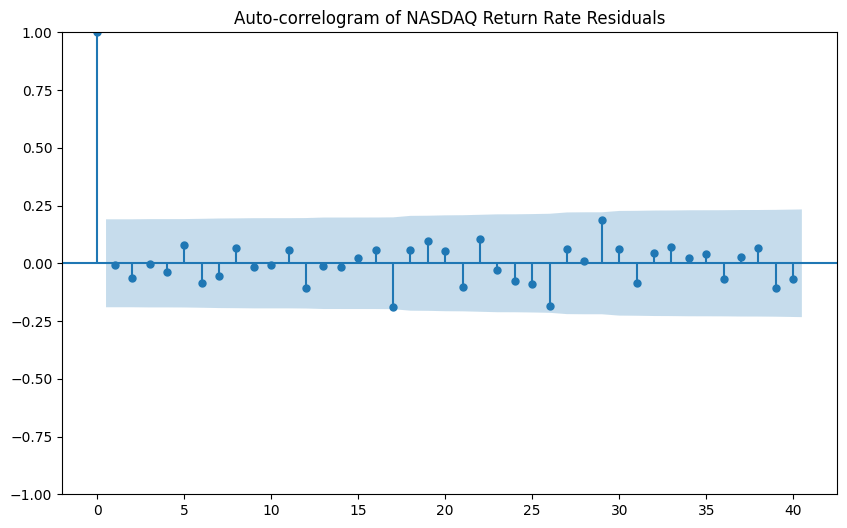

In [19]:
analyze_residuals(df_initial_data, 'NASDAQ')

ADF Statistic: -5.901338735898018
p-value: 2.773435796936191e-07


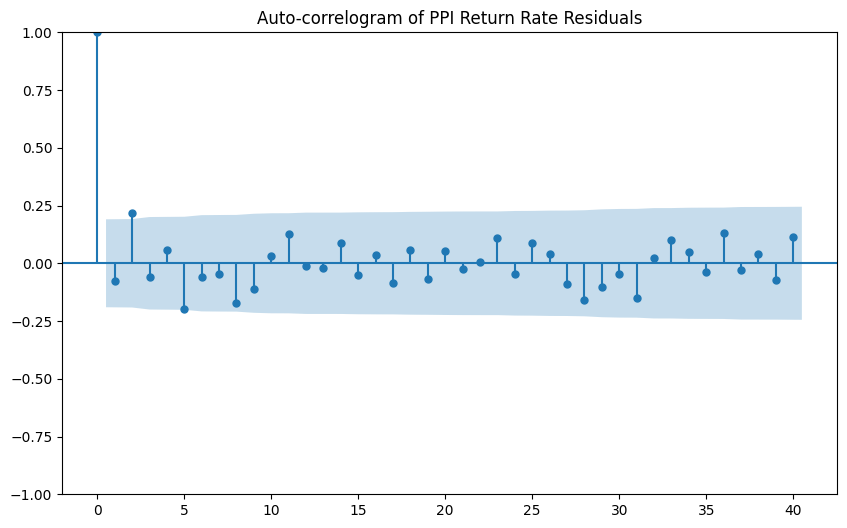

In [20]:
analyze_residuals(df_initial_data, 'PPI')

In [21]:
df_struct_breaks= df_initial_data.copy()

# Create dummy variable
df_struct_breaks['dummy'] = ((df_struct_breaks.index >= '01-07-2007') & (df_struct_breaks.index <= '01-07-2008')).astype(int)

# Display DataFrame
print(df_struct_breaks.head())


                 MSFT       NASDAQ    PPI  dummy
2005-01-01  26.328000  1539.802014  129.0      0
2005-02-01  25.837895  1521.409475  130.0      0
2005-03-01  24.735455  1499.492265  134.9      0
2005-04-01  24.786190  1447.271438  139.8      0
2005-05-01  25.469524  1489.885248  138.5      0


In [22]:
# Perform the Johansen Cointegration Test
# det_order = 0 for no deterministic trend, k_ar_diff = 1 for lag order
jres1 = coint_johansen(df_struct_breaks, det_order=0, k_ar_diff=1)

# You can then analyze the result 'jres' to understand the cointegration relationships.
# For example, to print the test statistic and critical values:
print("Eigenvalues:", jres1.eig)
print("Test Statistics:", jres1.lr1)
print("Critical Values (90%, 95%, 99%):", jres1.cvt)

# Checking for Cointegration
coint_test = select_coint_rank(df_struct_breaks, det_order=1, k_ar_diff=1, method='trace', signif=0.05)
print("Cointegration Test Results:")
print(coint_test.summary())


Eigenvalues: [0.18627306 0.10691871 0.07949329 0.01613335]
Test Statistics: [44.34022409 22.49039867 10.50416562  1.72408041]
Critical Values (90%, 95%, 99%): [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Cointegration Test Results:
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   4          47.27          55.25
-------------------------------------
